
## TURKISH
## Proje: Türkçe Metin Sınıflandırma
Bu projede, çeşitli Türkçe metinleri kategorilerine ayıran bir sınıflandırıcı geliştireceğiz. Kullanılacak model `SBERT` + `Gaussian Mixture Models (GMM)` olacak.

Veri kaynağı: Datas/data.csv
Hedef: 'content' sütunundaki metni kullanarak 'category' sütununu tahmin etmek.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import re

In [62]:
df = pd.read_csv('../../Datas/data.csv')
df.head()
df.sample(n=5)

,category,content
75,Bilimsel,"Galip Akay, (d. 1945, Şarkışla, Sivas) Türk as..."
924,Siyasi,1968 Türkiye Cumhuriyeti Milletvekili Ara Seçi...
787,Savaşlar,Şubat 2000 - Irak-İran sınırındaki Kandil Dağı...
1098,Spor,Elina Svitolina turnuvanın son şampiyonuydu an...
96,Bilimsel,"Türkiye Atom Enerjisi Kurumu, 1956 ve 2022 yıl..."


## İlk Gözlem
- `content`: metin verisi
- `category`: hedef sınıf (etiket)

In [63]:
# Boş değerleri sil.
# Küçük harfe çevir.
# Noktalama ve sayıları temizle.
# Stopwords temizliği yap.
# Stemming bu projede opsiyonel

nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df.dropna(subset=['content', 'category'], inplace=True)
df['processed_data'] = df['content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: xlabel='category'>

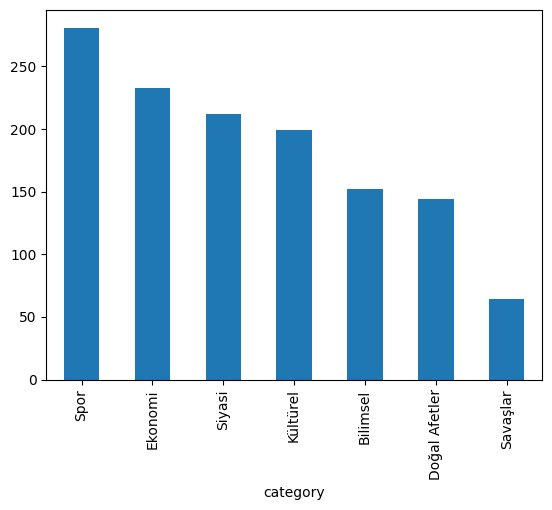

In [64]:
# Kategori dağılımını grafikle veya tabloda gör
df['category'].value_counts().plot(kind='bar')

In [73]:
from sentence_transformers import SentenceTransformer

# Türkçe metinler için uygun, hızlı bir SBERT modeli:
sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Embedding üretimi
X = sbert_model.encode(df['processed_data'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [72]:

#! Farklı bir sentenceTransformer denendi ama olmadı
# from sentence_transformers import SentenceTransformer

# # Türkçe metinler için uygun, hızlı bir SBERT modeli:
# sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

# # Embedding üretimi
# X = sbert_model.encode(df['processed_data'].tolist(), show_progress_bar=True)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np


# Label'ları sayısallaştır
le = LabelEncoder()
labels_num = le.fit_transform(df['category'])

# GMM kümeleme
gmm = GaussianMixture(n_components=15, covariance_type='diag', random_state=42)
gmm.fit(X)
clusters = gmm.predict(X)

### 🔹 GMM sonrası metrikler ###
gmm_sil = silhouette_score(X, clusters)
gmm_calinski = calinski_harabasz_score(X, clusters)
gmm_davies = davies_bouldin_score(X, clusters)

# Accuracy hesaplama (GMM için)
gmm_label_map = {}
for cluster_id in np.unique(clusters):
    mask = (clusters == cluster_id)
    cluster_labels = labels_num[mask]
    if len(cluster_labels) == 0:
        continue
    most_common_num = Counter(cluster_labels).most_common(1)[0][0]
    gmm_label_map[cluster_id] = most_common_num

gmm_predicted_nums = [gmm_label_map[c] if c in gmm_label_map else -1 for c in clusters]
gmm_valid_idx = [i for i, x in enumerate(gmm_predicted_nums) if x != -1]
gmm_filtered_true = labels_num[gmm_valid_idx]
gmm_filtered_pred = [gmm_predicted_nums[i] for i in gmm_valid_idx]
gmm_accuracy = accuracy_score(gmm_filtered_true, gmm_filtered_pred)

print("\n📊 GMM Clustering Sonuçları:")
print(f"Silhouette Score:        {gmm_sil:.4f}")
print(f"Calinski-Harabasz Index: {gmm_calinski:.4f}")
print(f"Davies-Bouldin Index:    {gmm_davies:.4f}")
print(f"GMM doğruluk:            {gmm_accuracy:.4f}")
for cid, cat_num in gmm_label_map.items():
    print(f"Cluster {cid} -> {le.inverse_transform([cat_num])[0]}")


### 🔹 Meta-Clustering (Agglomerative) ###
# GMM cluster merkezlerini hesapla
cluster_centers = []
for cid in np.unique(clusters):
    vecs = X[clusters == cid]
    center = np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(X.shape[1])
    cluster_centers.append(center)

cluster_centers = np.vstack(cluster_centers)

# Agglomerative clustering
n_meta_clusters = 7
agglo = AgglomerativeClustering(n_clusters=n_meta_clusters)
meta_cluster_labels = agglo.fit_predict(cluster_centers)

# GMM cluster ID → Meta cluster ID
gmm_to_meta_map = {
    original_cluster_id: meta_cluster_labels[i]
    for i, original_cluster_id in enumerate(np.unique(clusters))
}

# Her veri noktasına meta-cluster ID ata
final_clusters = np.array([gmm_to_meta_map[c] for c in clusters])

# Performans metrikleri (meta sonrası)
meta_sil = silhouette_score(X, final_clusters)
meta_calinski = calinski_harabasz_score(X, final_clusters)
meta_davies = davies_bouldin_score(X, final_clusters)

# Accuracy (meta sonrası)
meta_label_map = {}
for cluster_id in np.unique(final_clusters):
    mask = (final_clusters == cluster_id)
    cluster_labels = labels_num[mask]
    if len(cluster_labels) == 0:
        continue
    most_common_num = Counter(cluster_labels).most_common(1)[0][0]
    meta_label_map[cluster_id] = most_common_num

meta_predicted_nums = [meta_label_map[c] if c in meta_label_map else -1 for c in final_clusters]
meta_valid_idx = [i for i, x in enumerate(meta_predicted_nums) if x != -1]
meta_filtered_true = labels_num[meta_valid_idx]
meta_filtered_pred = [meta_predicted_nums[i] for i in meta_valid_idx]
meta_accuracy = accuracy_score(meta_filtered_true, meta_filtered_pred)

print("\n🧪 Meta-Clustering (Agglomerative) Sonuçları:")
print(f"Silhouette Score:        {meta_sil:.4f}")
print(f"Calinski-Harabasz Index: {meta_calinski:.4f}")
print(f"Davies-Bouldin Index:    {meta_davies:.4f}")
print(f"Meta-cluster doğruluk:   {meta_accuracy:.4f}")
for cid, cat_num in meta_label_map.items():
    print(f"Meta-Cluster {cid} -> {le.inverse_transform([cat_num])[0]}")



📊 GMM Clustering Sonuçları:
Silhouette Score:        0.0687
Calinski-Harabasz Index: 46.3980
Davies-Bouldin Index:    2.2179
GMM doğruluk:            0.7292
Cluster 0 -> Ekonomi
Cluster 1 -> Siyasi
Cluster 2 -> Spor
Cluster 3 -> Spor
Cluster 4 -> Doğal Afetler
Cluster 5 -> Kültürel
Cluster 6 -> Bilimsel
Cluster 7 -> Kültürel
Cluster 8 -> Bilimsel
Cluster 9 -> Spor
Cluster 10 -> Savaşlar
Cluster 11 -> Spor
Cluster 12 -> Kültürel
Cluster 13 -> Siyasi
Cluster 14 -> Spor

🧪 Meta-Clustering (Agglomerative) Sonuçları:
Silhouette Score:        0.0720
Calinski-Harabasz Index: 52.0385
Davies-Bouldin Index:    1.8371
Meta-cluster doğruluk:   0.5393
Meta-Cluster 0 -> Ekonomi
Meta-Cluster 1 -> Spor
Meta-Cluster 2 -> Kültürel
Meta-Cluster 3 -> Spor
Meta-Cluster 4 -> Siyasi
Meta-Cluster 5 -> Bilimsel
Meta-Cluster 6 -> Spor


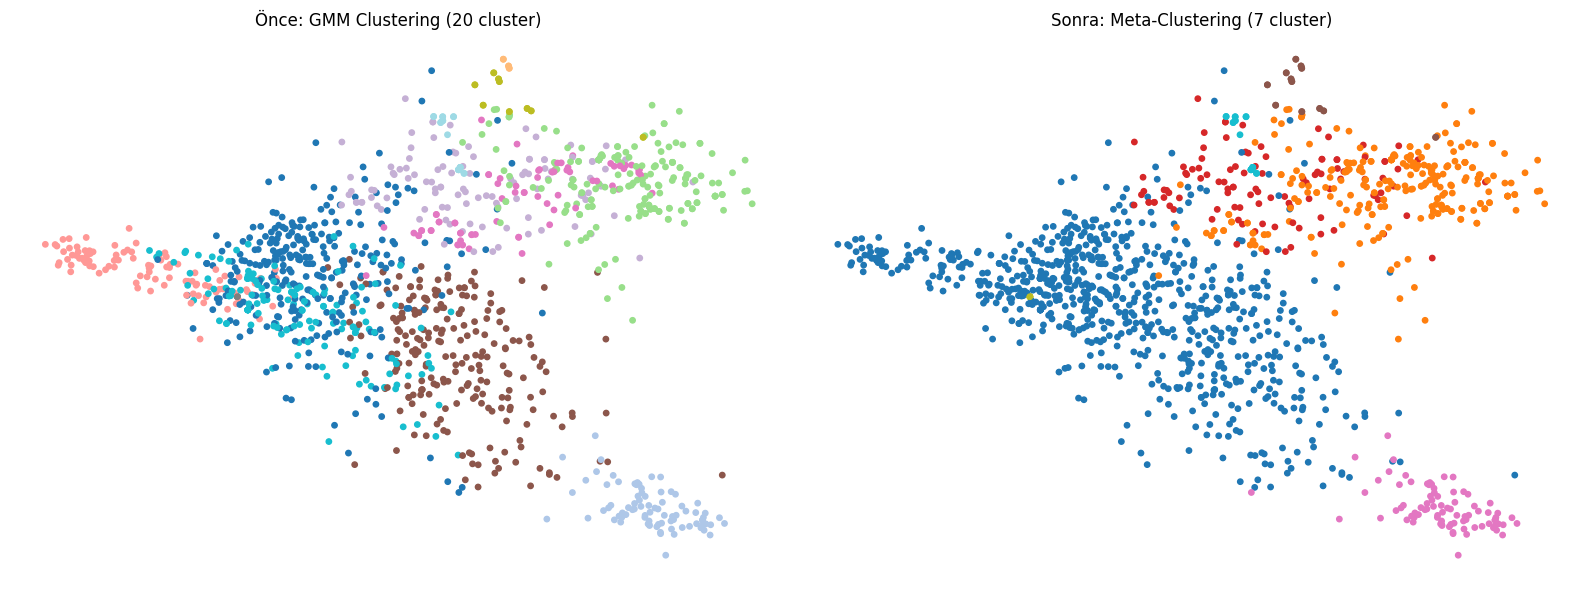

In [69]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# 1. GMM ile clustering sonucu
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab20', s=15)
axs[0].set_title("Önce: GMM Clustering (20 cluster)")
axs[0].axis("off")

# 2. Meta-clustering sonucu
axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c=final_clusters, cmap='tab10', s=15)
axs[1].set_title("Sonra: Meta-Clustering (7 cluster)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import joblib
import os

target_base_dir = '../../Models/SBERT'

# Modelin tam kaydedileceği yol
model_save_path = os.path.join(target_base_dir, 'gmm_model.joblib')

try:
    # Hedef dizini oluştur. exist_ok=True sayesinde zaten varsa hata vermez.
    os.makedirs(target_base_dir, exist_ok=True)
    print(f"'{target_base_dir}' dizini başarıyla oluşturuldu veya zaten mevcut.")
    print(f"Modelin kaydedileceği tam yol: {os.path.abspath(model_save_path)}") # Tam yolu gösterelim
except Exception as e:
    print(f"Dizin oluşturulurken bir hata oluştu: {e}")
    exit()


# Modeli kaydet
try:
    joblib.dump(gmm, model_save_path)
    print(f"Model '{model_save_path}' konumuna başarıyla kaydedildi.")
    joblib.dump(X, '../../Models/SBERT/embeddings.joblib')
    print(f"Embeddings '{model_save_path}' konumuna başarıyla kaydedildi.")
except Exception as e:
    print(f"Model kaydedilirken bir hata oluştu: {e}")

'../../Models/SBERT' dizini başarıyla oluşturuldu veya zaten mevcut.
Modelin kaydedileceği tam yol: c:\Users\uslan\OneDrive\Desktop\CENG Notes\3.Sınıf Dersleri\Machine Learning\Dejaview-CENG3522\Models\SBERT\gmm_model.joblib
Model '../../Models/SBERT\gmm_model.joblib' konumuna başarıyla kaydedildi.
Model '../../Models/SBERT\gmm_model.joblib' konumundan başarıyla yüklendi.
Yüklenen model içeriği: GaussianMixture(covariance_type='diag', n_components=15, random_state=42)


C:\Users\uslan\AppData\Local\Temp\ipykernel_2824\2341175071.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters)


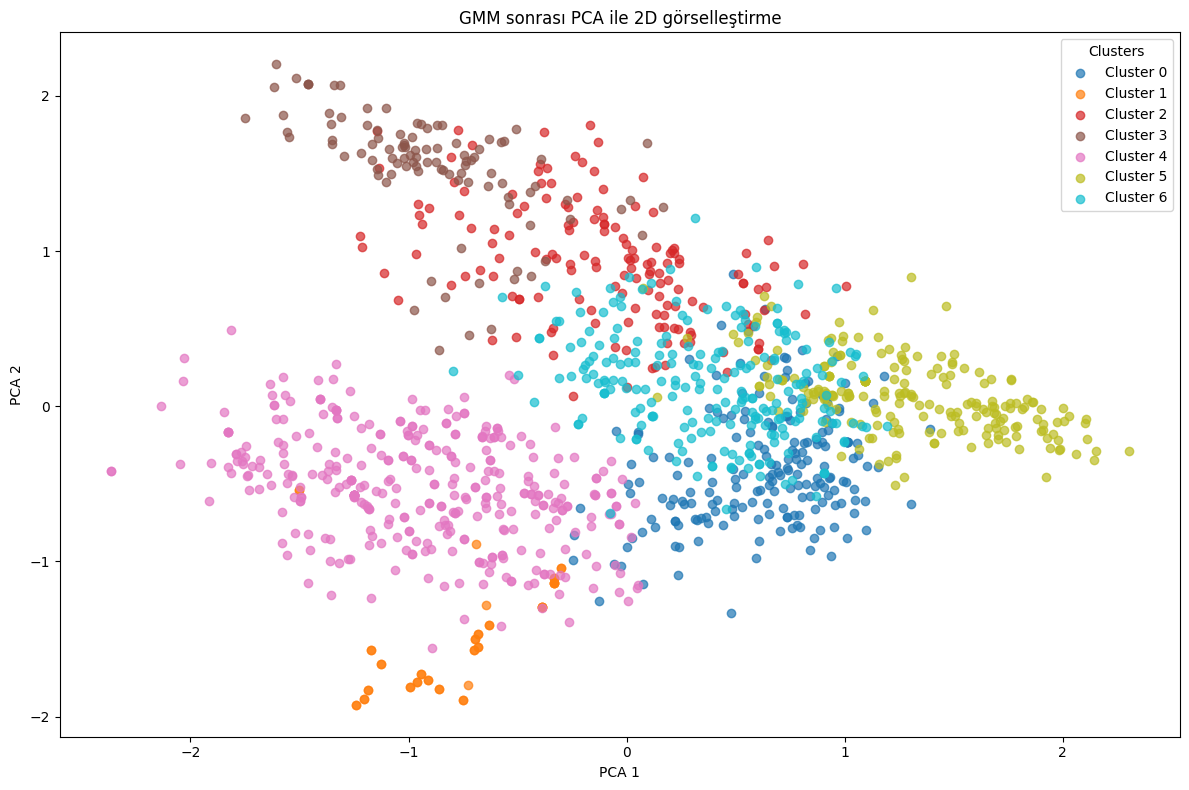

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters)
colors = plt.cm.get_cmap('tab10', num_clusters)

plt.figure(figsize=(12,8))

for i, cluster_id in enumerate(unique_clusters):
    idx = np.where(clusters == cluster_id)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], 
                color=colors(i), 
                label=f"Cluster {cluster_id}", 
                alpha=0.7)

plt.title('GMM sonrası PCA ile 2D görselleştirme')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title="Clusters", loc='upper right')
plt.tight_layout()
plt.show()


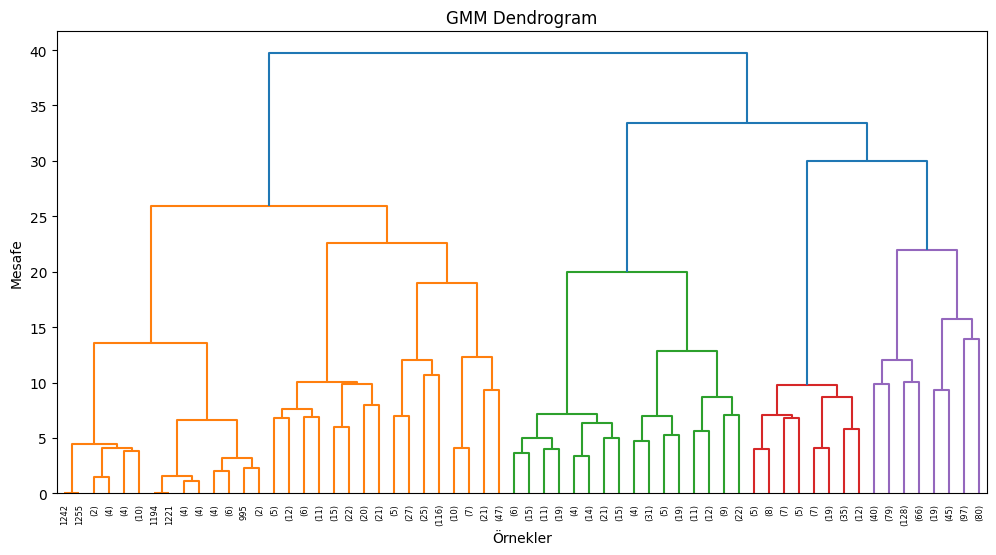

In [10]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)  # sadece ilk 5 seviyeyi gösterir
plt.title('GMM Dendrogram')
plt.xlabel('Örnekler')
plt.ylabel('Mesafe')
plt.show()

## Grafik: Gerçek ve Tahmin Edilen Oranlar

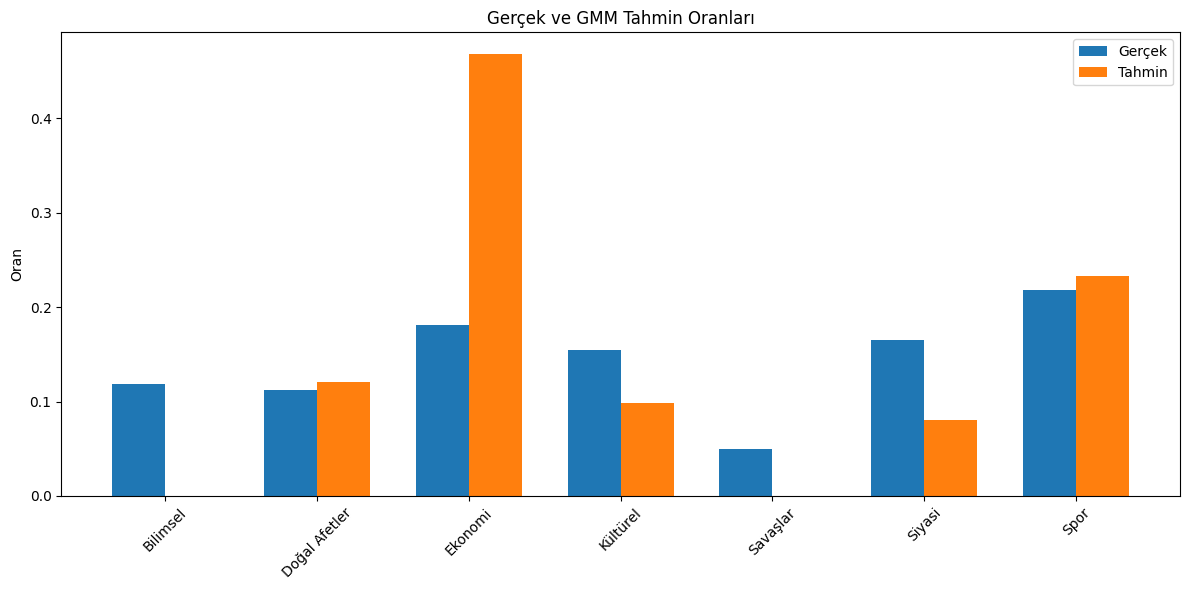

In [56]:
true_counts = df['category'].value_counts(normalize=True).sort_index()
predicted_categories = le.inverse_transform(filtered_pred)
predicted_counts = pd.Series(predicted_categories).value_counts(normalize=True).sort_index()

all_categories = sorted(set(true_counts.index).union(predicted_counts.index))
true_vals = [true_counts.get(cat, 0) for cat in all_categories]
predicted_vals = [predicted_counts.get(cat, 0) for cat in all_categories]

x = np.arange(len(all_categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, true_vals, width, label='Gerçek')
ax.bar(x + width/2, predicted_vals, width, label='Tahmin')
ax.set_ylabel('Oran')
ax.set_title('Gerçek ve GMM Tahmin Oranları')
ax.set_xticks(x)
ax.set_xticklabels(all_categories, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()